In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from datetime import timedelta
import json
import itertools
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore")

# Determining Adopted Users

In [2]:
user_df = pd.read_csv("takehome_user_engagement.csv")

In [3]:
user_df.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
user_df.shape

(207917, 3)

In [6]:
user_df.time_stamp = user_df.time_stamp.astype("datetime64")

In [7]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [8]:
user_df["Date"] = user_df.time_stamp.apply(lambda x: x.date())
user_df.head()

,time_stamp,user_id,visited,Date
0,2014-04-22 03:53:30,1,1,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-12-25


In [9]:
adopted_map = {}
for user in list(user_df.user_id.unique()):
    tempdf = user_df[user_df.user_id == user]
    mindate = tempdf.time_stamp.min()
    maxdate = tempdf.time_stamp.max()
    if maxdate - timedelta(days = 7) < mindate:
        adopted_map[user] = 0
    elif len(tempdf.Date.unique()) < 3:
        adopted_map[user] = 0
    else:
        adopted_map[user] = 1

# Building Predictive Model

In [71]:
df = pd.read_csv("takehome_users.csv", encoding = "ISO-8859-1")

In [72]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [74]:
df = df[df.last_session_creation_time.isnull() == False]

In [75]:
df.creation_time = df.creation_time.astype("datetime64")

In [76]:
df.last_session_creation_time = df.last_session_creation_time.apply(lambda x: datetime.utcfromtimestamp(x))

In [77]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [78]:
df["adopted"] = df.object_id.map(adopted_map)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            4776 non-null float64
adopted                       8823 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)
memory usage: 827.2+ KB


In [80]:
df.invited_by_user_id = df.invited_by_user_id.fillna(0)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     8823 non-null int64
creation_time                 8823 non-null datetime64[ns]
name                          8823 non-null object
email                         8823 non-null object
creation_source               8823 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      8823 non-null int64
enabled_for_marketing_drip    8823 non-null int64
org_id                        8823 non-null int64
invited_by_user_id            8823 non-null float64
adopted                       8823 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(5), object(3)
memory usage: 827.2+ KB


In [82]:
df = df.drop(["name", "email"], axis = 1)

In [83]:
pull_date = df.last_session_creation_time.max()
min_req_date = pull_date - timedelta(days = 7)
min_req_date

Timestamp('2014-05-30 14:58:50')

In [84]:
df["requirement"] = np.where(df.creation_time < min_req_date, 1, 0)

In [88]:
df[df.requirement == 0].head(10)

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,requirement
149,150,2014-05-30 20:30:10,SIGNUP,2014-05-30 20:30:10,0,0,10,0.0,0,0
233,234,2014-05-30 15:44:36,SIGNUP_GOOGLE_AUTH,2014-05-30 15:44:36,0,0,191,0.0,0,0
719,720,2014-05-30 19:52:23,ORG_INVITE,2014-06-01 19:52:23,1,0,97,5200.0,0,0
1888,1889,2014-05-30 21:24:54,SIGNUP_GOOGLE_AUTH,2014-05-30 21:24:54,0,0,144,0.0,0,0
3489,3490,2014-05-30 23:45:01,PERSONAL_PROJECTS,2014-05-31 23:45:01,0,0,31,0.0,0,0
4244,4245,2014-05-30 19:19:39,ORG_INVITE,2014-05-30 19:19:39,0,0,24,8526.0,0,0
5583,5584,2014-05-30 21:34:28,GUEST_INVITE,2014-05-31 21:34:28,0,0,86,8152.0,0,0
6052,6053,2014-05-30 23:59:19,GUEST_INVITE,2014-05-30 23:59:19,1,0,7,3421.0,0,0
6533,6534,2014-05-30 20:30:45,SIGNUP_GOOGLE_AUTH,2014-05-30 20:30:45,0,0,228,0.0,0,0
6849,6850,2014-05-30 18:32:29,ORG_INVITE,2014-05-30 18:32:29,0,0,172,11873.0,0,0


In [89]:
df[df.requirement == 0].shape

(23, 10)

In [90]:
df.shape

(8823, 10)

In [91]:
df = df[df.requirement == 1]

In [92]:
df.shape

(8800, 10)

In [94]:
df = df.drop(["creation_time", "last_session_creation_time", "requirement"], axis = 1)

In [96]:
df.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,GUEST_INVITE,1,0,11,10803.0,0
1,2,ORG_INVITE,0,0,1,316.0,1
2,3,ORG_INVITE,0,0,94,1525.0,0
3,4,GUEST_INVITE,0,0,1,5151.0,0
4,5,GUEST_INVITE,0,0,193,5240.0,0


In [97]:
df.creation_source.unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [99]:
source_map = {}
for i, source in zip(range(len(list(df.creation_source.unique()))), list(df.creation_source.unique())):
    source_map[source] = i

In [101]:
df.creation_source = df.creation_source.map(source_map)

In [104]:
df.head()

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,0,1,0,11,10803.0,0
1,2,1,0,0,1,316.0,1
2,3,1,0,0,94,1525.0,0
3,4,0,0,0,1,5151.0,0
4,5,0,0,0,193,5240.0,0


In [105]:
df.shape

(8800, 7)

In [110]:
df = df.set_index("object_id")

In [111]:
df

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,
1,0,1,0,11,10803.0,0
2,1,0,0,1,316.0,1
3,1,0,0,94,1525.0,0
4,0,0,0,1,5151.0,0
5,0,0,0,193,5240.0,0
6,0,0,0,197,11241.0,0
7,2,0,1,37,0.0,0
10,1,1,1,318,4143.0,1
11,2,0,0,69,0.0,0


In [112]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import mean_squared_error, roc_auc_score, mean_absolute_error
from sklearn.preprocessing import Normalizer, normalize

In [113]:
X = np.array(df.drop("adopted", axis = 1))
y = np.array(df.adopted)
feature_list = list(df.columns.drop("adopted"))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 42)

In [114]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Validation Features Shape:', X_val.shape)
print('Validation Labels Shape:', y_val.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (4928, 5)
Training Labels Shape: (4928,)
Validation Features Shape: (1232, 5)
Validation Labels Shape: (1232,)
Testing Features Shape: (2640, 5)
Testing Labels Shape: (2640,)


In [131]:
X_t = np.array(df).T
dendro_features = list(df.columns)

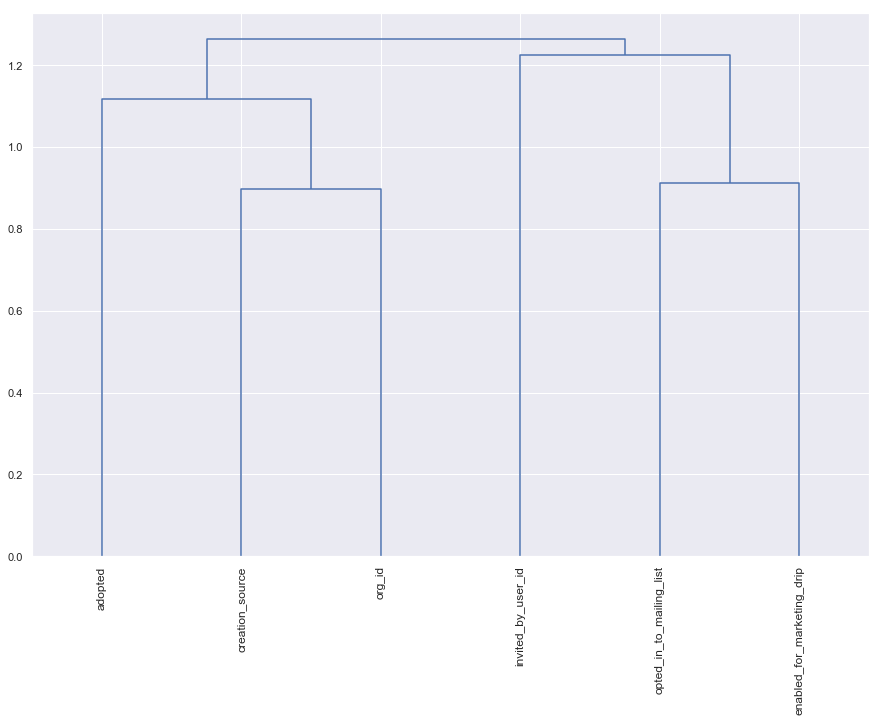

In [133]:
X_norm = normalize(X_t)
mergings = linkage(X_norm, method = "complete")
plt.figure(figsize = (15, 10))
dendrogram(mergings, labels = dendro_features, leaf_rotation = 90)
plt.show()

In [117]:
# n_estimator tuning
estimator_options = [5, 7, 10, 15, 20]
estimator_scores = []
estimator_mses = []
for estimator in estimator_options:
    model = RandomForestRegressor(n_estimators = estimator, random_state = 42)
    model.fit(X, y)
    y_pred = model.predict(X_val)
    estimator_scores.append(model.score(X_val, y_val))
    estimator_mses.append(mean_squared_error(y_val, y_pred))

In [118]:
for i in range(len(estimator_options)):
    print("n_estimator: {}, R^2: {}, MSE: {}".format(estimator_options[i],  
                                                     estimator_scores[i], 
                                                     estimator_mses[i]))

n_estimator: 5, R^2: 0.5014644138318238, MSE: 0.09566128475022322
n_estimator: 7, R^2: 0.5244501355163945, MSE: 0.09125067951307704
n_estimator: 10, R^2: 0.5409795226996452, MSE: 0.08807894522177567
n_estimator: 15, R^2: 0.5556245655558667, MSE: 0.08526878752447614
n_estimator: 20, R^2: 0.5632731369713623, MSE: 0.08380114471539629


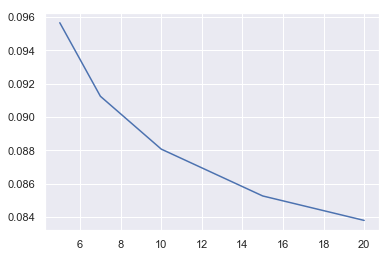

In [119]:
sns.lineplot(x = estimator_options, y = estimator_mses)

In [120]:
# max_depth tuning, with n_estimator = 15
depth_options = [2, 5, 7, 10, 15]
depth_oobs = []
depth_scores = []
depth_mses = []
for depth in depth_options:
    model = RandomForestRegressor(n_estimators = 15, max_depth = depth, random_state = 42)
    model.fit(X, y)
    y_pred = model.predict(X_val)
    depth_scores.append(model.score(X_val, y_val))
    depth_mses.append(mean_squared_error(y_val, y_pred))

In [121]:
for i in range(len(depth_options)):
    print("max_depth: {}, R^2: {}, MSE: {}".format(depth_options[i], depth_scores[i], depth_mses[i]))

max_depth: 2, R^2: 0.021806675618746274, MSE: 0.18770020183240416
max_depth: 5, R^2: 0.039899910136892425, MSE: 0.18422838937344546
max_depth: 7, R^2: 0.0685641380149834, MSE: 0.17872816643797315
max_depth: 10, R^2: 0.15482769065527735, MSE: 0.16217552204980448
max_depth: 15, R^2: 0.3521362483122512, MSE: 0.1243150550312828


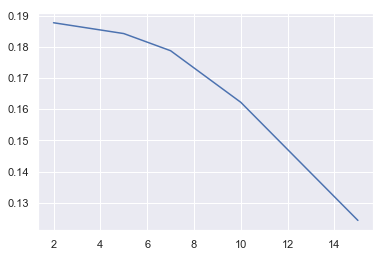

In [122]:
sns.lineplot(x = depth_options, y = depth_mses)

In [123]:
# max_features tuning, with n_estimator = 15 and max_depth = 15
feature_options = [1, 2, 3, 4, 5]
feature_scores = []
feature_mses = []
for feature in feature_options:
    model = RandomForestRegressor(n_estimators = 15, max_depth = 15, max_features= feature, 
                                  random_state = 42)
    model.fit(X, y)
    y_pred = model.predict(X_val)
    feature_scores.append(model.score(X_val, y_val))
    feature_mses.append(mean_squared_error(y_val, y_pred))

In [124]:
for i in range(len(feature_options)):
    print("max_feature: {}, R^2: {}, MSE: {}".format(feature_options[i], feature_scores[i], feature_mses[i]))

max_feature: 1, R^2: 0.37772472593031975, MSE: 0.1194050211005836
max_feature: 2, R^2: 0.3914116984937773, MSE: 0.1167787023059214
max_feature: 3, R^2: 0.37585595131766564, MSE: 0.11976361010669474
max_feature: 4, R^2: 0.35122815878503644, MSE: 0.12448930339639806
max_feature: 5, R^2: 0.3521362483122512, MSE: 0.1243150550312828


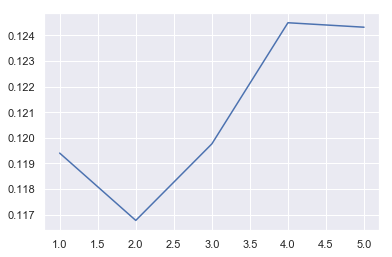

In [125]:
sns.lineplot(x = feature_options, y = feature_mses)

In [126]:
X_test = np.concatenate((X_val, X_test))
y_test = np.concatenate((y_val, y_test))

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (4928, 5)
Training Labels Shape: (4928,)
Testing Features Shape: (3872, 5)
Testing Labels Shape: (3872,)


In [127]:
rf = RandomForestRegressor(n_estimators = 15, max_depth = 20, max_features = 2, random_state = 42)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=15, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [128]:
y_pred = rf.predict(X_test)

print("R^2: {}".format(rf.score(X_test, y_test)))
print("Mean Squared Error: {}".format(mean_squared_error(y_test, y_pred)))

R^2: -0.22922049742990414
Mean Squared Error: 0.2295234997259423


In [129]:
#Quantifying feature importance
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
feature_importances_sorted = sorted(feature_importances, key = lambda x: x[1], reverse = True)

for pair in feature_importances_sorted:
    print("Variable: {:25} Importance: {}".format(pair[0], pair[1]))

Variable: org_id                    Importance: 0.5991
Variable: invited_by_user_id        Importance: 0.3215
Variable: creation_source           Importance: 0.0419
Variable: opted_in_to_mailing_list  Importance: 0.0213
Variable: enabled_for_marketing_drip Importance: 0.0162


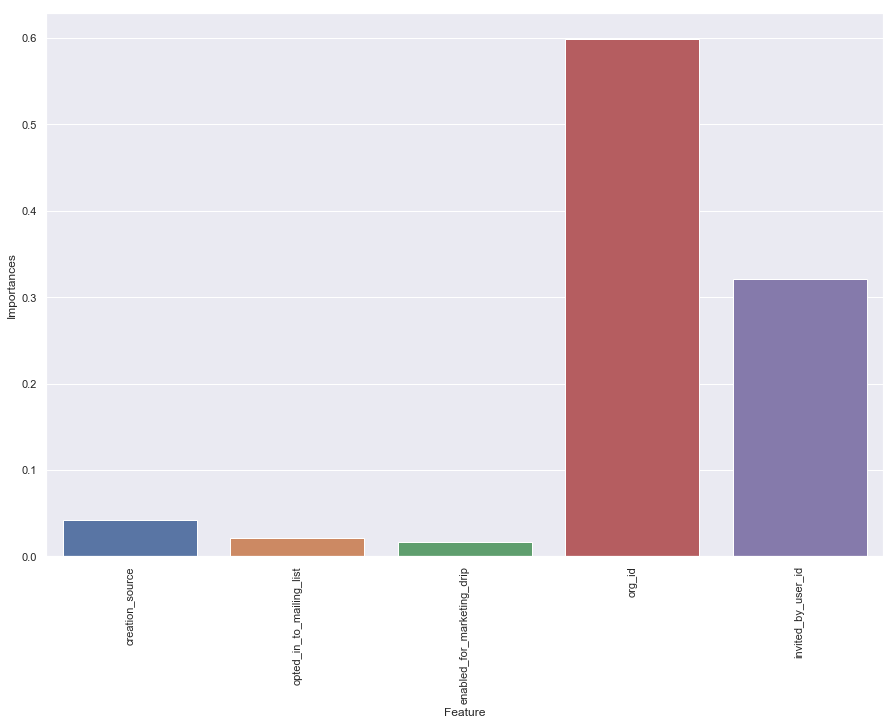

In [130]:
x_vals = list(range(len(importances)))
plt.figure(figsize = (15, 10))
sns.barplot(x_vals, importances, orientation = "vertical")
plt.xticks(x_vals, feature_list, rotation = "vertical")
plt.ylabel("Importances")
plt.xlabel("Feature")
plt.show()